In [1458]:
import taichi as ti
import numpy as np
ti.init(arch=ti.cuda) # Set to cpu if you have no gpu



[Taichi] Starting on arch=cuda


In [1459]:


class LBM2D:
    def __init__(self,width:float,height:float,element_length:float,viscosity:float,speed:float,density:float,float_type = ti.f32) -> None:
        
        self.dimensions = 2

        directions,weights = self.DQ29()
        self.bounding_box = (width,height)
        self.float_type = float_type
        self.shape = (int(width//element_length),int(height//element_length))
        # self.offset = (int(-1),int(-1))
        self.offset = (0,0)
        self.fluid_shape = tuple([s for s in self.shape])
        print(self.shape)
        self.f = ti.Vector.field(n = 9,dtype= self.float_type,shape = self.shape,offset = self.offset)
        self.f_next = ti.Vector.field(n = 9,dtype= self.float_type,shape = self.shape,offset = self.offset)
        self.density = ti.field(self.float_type,shape = self.shape,offset = self.offset)
        self.pressure = ti.field(self.float_type,shape = self.shape,offset = self.offset)
        self.velocity = ti.Vector.field(n = 2, dtype= self.float_type, shape = self.shape,offset = self.offset)

        # Boundary Fields
        self.boundary_condition = ti.field(dtype=ti.int8,shape = self.shape,offset = self.offset)
        self.boundary_value = ti.Vector.field(n=2,dtype=self.float_type,shape= self.shape,offset = self.offset)
        self.boundary_to_reflect = ti.Vector.field(n = 9,dtype=ti.int8,shape =self.shape,offset = self.offset)
        self.boundary_reflect_indices = ti.Vector([0,3,4,1,2,7,8,5,6],dt = ti.int8)

        # lattice velocities and weighting
        self.lattice_velocities = ti.Vector.field(n = 2 ,dtype=ti.int8,shape = (9,))
        self.lattice_weights = ti.field(dtype=self.float_type,shape = (9,))

        self.lattice_velocities.from_numpy(directions)
        self.lattice_weights.from_numpy(weights)

        # Physcial Constants
        self.physical_viscosity:float = viscosity
        self.physical_dx = 1
        self.physical_speed = speed
        self.physical_density = density
        self.physical_dt = self.physical_dx/self.physical_speed

        #Scaling factors
        self.conversion_dt = self.physical_dx/self.physical_speed
        self.conversion_x = self.physical_dx
        self.conversion_speed = (3**0.5)*self.physical_speed
        self.conversion_viscosity = self.physical_speed*self.conversion_x
        self.conversion_density = density
        
        # Non dimensionalised quantities
        self.dt:float = 1.
        self.dx:float = 1.
        self.cs:float = 1/(3**0.5)
        
        self.viscosity = self.physical_viscosity#/self.conversion_viscosity
        # self.tau = self.viscosity/(self.cs**2*self.dt) + 0.5 
        self.tau = 0.52
        self.Re = self.physical_speed*self.conversion_x/self.physical_viscosity
        # Set initial fields
        self.initialise()

    def DQ29(self):
        directions = np.array([
                [ 0,  0],  # Rest particle
                [ 1,  0],  # Right
                [ 0,  1],  # Up
                [-1,  0],  # Left
                [ 0, -1],  # Down
                [ 1,  1],  # Top-right
                [-1,  1],  # Top-left
                [-1, -1],  # Bottom-left
                [ 1, -1]   # Bottom-right
            ])
        weights = np.array([
            4/9,
            1/9,
            1/9,
            1/9,
            1/9,
            1/36,
            1/36,
            1/36,
            1/36, 
        ])
        return directions,weights
    
    def initialise(self,perturbation = False):
        self.f.fill(1/9)
        self.f_next.fill(1/9)

        self.boundary_condition.fill(0)
        self.boundary_value.fill(0)
        self.boundary_to_reflect.fill(0)

        if perturbation:
            pass
        else:
            self.density.fill(1.)
            self.velocity.fill(0.)

    def reset_fields(self):
        self.f = self.f_next
        self.f_next = ti.Vector.field(n = 9,dtype= self.float_type,shape = self.shape,offset = self.offset)


In [1460]:

Re = 1000
v = 1*1/Re
LBM = LBM2D(1,1,1/256,viscosity=v,speed = 1,density= 1000,float_type=ti.f64)
LBM.tau,LBM.Re


(256, 256)


(0.52, 1000.0)

In [1461]:
@ti.func
def set_reflection(to_reflect,boundary,opposite_indices):
    for k in ti.static(range(len(to_reflect))):
        boundary[to_reflect[k]] = opposite_indices[to_reflect[k]]
    return boundary

@ti.kernel
def set_walls_BC():
    shape = LBM.fluid_shape
    #i is x and j is y and starts at lower left corner so we want top to be velocity
    opposites = LBM.boundary_reflect_indices
    for i,j in ti.ndrange(*LBM.fluid_shape):
        # print(i,j)
        if (i ==0) or (j == 0) or (i ==(shape[0]-1)): # or (j == (shape[-1]-1))  :
            LBM.boundary_condition[i,j] = 1
            #Left and right Wall
            if i == 0: # Left Wall
                to_reflect = [3,7,6]
                LBM.boundary_to_reflect[i,j] = set_reflection(to_reflect,LBM.boundary_to_reflect[i,j],opposites)
                
            elif i == (shape[0]-1): # Must be right wall
                to_reflect = [5,1,8]
                LBM.boundary_to_reflect[i,j] = set_reflection(to_reflect,LBM.boundary_to_reflect[i,j],opposites)
                
            if j == 0: # Bottom Wall
                to_reflect = [7,4,8]
                LBM.boundary_to_reflect[i,j] = set_reflection(to_reflect,LBM.boundary_to_reflect[i,j],opposites)
        # Top Wall
        elif j == (shape[-1]-1):
            LBM.boundary_condition[i,j] = 2
            LBM.boundary_value[i,j] = ti.math.vec2(0.1,0.)
            to_reflect = [6,2,5]
            LBM.boundary_to_reflect[i,j] = set_reflection(to_reflect,LBM.boundary_to_reflect[i,j],opposites)
            

In [1462]:
@ti.kernel
def collision():
    for i,j in ti.ndrange(*LBM.fluid_shape):
        density = LBM.density[i,j]
        velocity = LBM.velocity[i,j]
        
        for k in ti.static(range(LBM.f.n)):
            # pass
            term_1 = LBM.lattice_velocities[k].dot(velocity)/LBM.cs**2
            term_2 = (term_1**2)/2
            term_3 =  velocity.dot(velocity)/(2*LBM.cs**2)

            f_eq = LBM.lattice_weights[k]*density*(1+ term_1 + term_2 - term_3)

            LBM.f[i,j][k] = LBM.f[i,j][k] - (1/LBM.tau)*(LBM.f[i,j][k] - f_eq)



In [1463]:
@ti.kernel
def streaming():
    for i,j in ti.ndrange(*LBM.fluid_shape):
        for k in ti.static(range(LBM.f.n)):

            vel_dir = LBM.lattice_velocities[k]
            i_stream = int(i - vel_dir[0]) 
            j_stream = int(j - vel_dir[1]) 
            
            
            if (i_stream > -1) and (i_stream < LBM.shape[0]) and ( j_stream > -1) and (j_stream < LBM.shape[1]):    
                # print(i_stream,j_stream)     
                
                f_stream = LBM.f[i_stream,j_stream]

                LBM.f_next[i,j][k] = f_stream[k]  # Pull from neighbors
            else:
                # This is for directions stemming from corners. We just update the f_next[i.j][k] with the same f after collision
                LBM.f_next[i, j][k] = LBM.f[i, j][k]


In [1464]:
@ti.func
def halfway_bounceback(f_vec,bc_reflections):
    for k in ti.static(range(f_vec.n)):
        if bc_reflections[k] > 0:
            reflect_idx = bc_reflections[k]
            f_vec[reflect_idx] = f_vec[k]
    return f_vec

@ti.func
def wall_density(f_vec,bc_reflections):
    density:ti.f64 = 0.
    for k in ti.static(range(f_vec.n)):
        if bc_reflections[k] == 0:
            density += f_vec[k]
    return density

@ti.func
def halfway_bounceback_moving_wall(f_vec,bc_reflections,wall_velocity,lattice_weights,lattice_velocities,cs,density):
    # density = 

    for k in ti.static(range(f_vec.n)):
        if bc_reflections[k] > 0:
            reflect_idx = bc_reflections[k]
            
            df = 2*lattice_weights[k]*density*(wall_velocity.dot(lattice_velocities[k]))/(cs**2)
            f_vec[reflect_idx] = f_vec[k] - df
            # print(f'k = {k}, reflect_idx = {reflect_idx} df = {df} f_reflect = { f_vec[reflect_idx]},f_vec = {f_vec},density = {f_vec.sum()}')
    return f_vec

@ti.kernel
def apply_Boundary_Condition():
    for i,j in ti.ndrange(*LBM.fluid_shape):
        # No Slip
        reflect_vec =LBM.boundary_to_reflect[i,j] 
        
        if LBM.boundary_condition[i,j] == 1 :        
            LBM.f_next[i,j] = halfway_bounceback(LBM.f_next[i,j],reflect_vec)
    
        # Moving Wall
        elif LBM.boundary_condition[i,j] == 2:
            u = LBM.boundary_value[i,j]
            density = wall_density(LBM.f_next[i,j],reflect_vec)            
            LBM.f_next[i,j] = halfway_bounceback_moving_wall(LBM.f_next[i,j],reflect_vec,u,LBM.lattice_weights,LBM.lattice_velocities,LBM.cs,density)


In [1465]:

@ti.func
def compute_velocity(f_vec,density,lattice_velocities):
    vec = ti.math.vec2(0.,0.)
    for k in range(f_vec.n):
        vec += f_vec[k]*lattice_velocities[k]
    return vec/density


@ti.kernel
def compute_macroscopic():
    for i,j in ti.ndrange(*LBM.fluid_shape):
        f_vec = LBM.f_next[i,j]
        LBM.density[i,j] = f_vec.sum()
        LBM.velocity[i,j] = compute_velocity(f_vec,LBM.density[i,j],LBM.lattice_velocities)


In [1466]:

print(LBM.tau,LBM.Re)
import matplotlib.cm as cm
gui = ti.GUI(res= LBM.shape)
for t in range(100_000):
    rho_old = LBM.density.to_numpy().mean()
    set_walls_BC()
    collision()
    streaming()
    apply_Boundary_Condition()
    compute_macroscopic()
    LBM.f.copy_from(LBM.f_next)

    if (t % 100) == 0:
        rho = LBM.density.to_numpy()
        rho_drift = rho.mean()-rho_old
        print(f't = {t} , density = {rho.mean()},drift = {rho_drift}')
    
        

0.52 1000.0
t = 0 , density = 0.9999999931225413,drift = -6.877458713638873e-09
t = 100 , density = 0.9999969226815324,drift = -9.131211220481106e-08
t = 200 , density = 0.9999874429735411,drift = -9.372713605237948e-08
t = 300 , density = 0.9999779719784426,drift = -9.561548464098735e-08
t = 400 , density = 0.9999683899565713,drift = -9.567504533070093e-08
t = 500 , density = 0.9999586289656217,drift = -1.0128094918293584e-07
t = 600 , density = 0.9999488602415623,drift = -9.544451939902387e-08
t = 700 , density = 0.9999393179641696,drift = -9.539183332130108e-08
t = 800 , density = 0.9999297936960861,drift = -9.508843712424664e-08
t = 900 , density = 0.9999204930799077,drift = -9.327703764938633e-08
t = 1000 , density = 0.9999106368415407,drift = -9.787556964901967e-08
t = 1100 , density = 0.9999011534032258,drift = -9.471178752384901e-08
t = 1200 , density = 0.999891673449123,drift = -9.476586759760153e-08
t = 1300 , density = 0.9998823049351698,drift = -9.374582221610694e-08
t = 14

KeyboardInterrupt: 

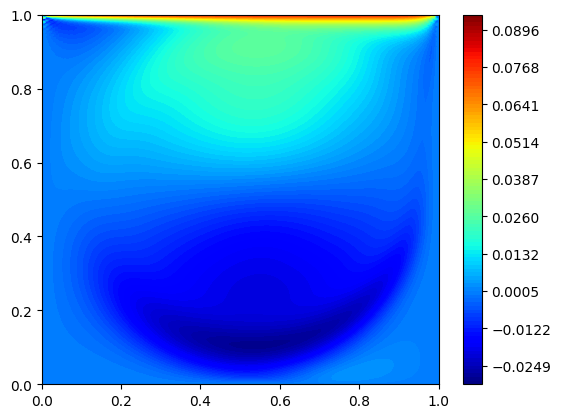

: 

In [ ]:

import matplotlib.pyplot as plt
X,Y = np.meshgrid(np.linspace(0,1,LBM.shape[0]),np.linspace(0,1,LBM.shape[1]))
arr = LBM.velocity.to_numpy()
rho = LBM.density.to_numpy()
u = arr[:,:,0]
v = arr[:,:,1]
z = u
plt.contourf(Y,X,z,cmap='jet',levels = np.linspace(z.min(),z.max(),100))
plt.colorbar()

In [1435]:
u.mean()

np.float64(0.0006563152319390996)

TypeError: Shapes of x (101, 101) and z (11, 11) do not match

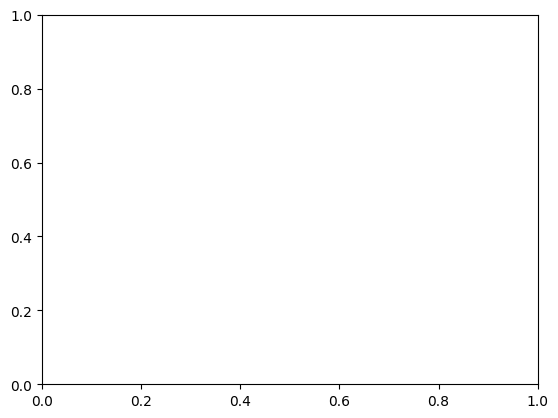